In [1]:
# Package installation
# install.packages('dplyr')
# install.packages('jsonlite')
# install.packages('lubridate')
# install.packages('ggplot2')
# install.packages('quantmod')
# install.packages('lifecycle')
# install.packages('tidyselect')
# install.packages("tidyverse")
# install.packages("zoo")


In [2]:
# Load necessary libraries
library(dplyr)
library(jsonlite)
library(lubridate)
library(ggplot2)
library(quantmod)
library(lifecycle)
library(tidyselect)
library(tidyverse)
library(zoo)



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::la

In [3]:
# Read the CSV file into a dataframe
WIN_PRO_df <- read.csv("csv_files/win_data_pro.csv")
PLACE_PRO_df <- read.csv("csv_files/place_data_PRO.csv")

In [4]:
# Filter only on the rows where actual trades have been made
WIN_PRO_df <- WIN_PRO_df %>% filter(trades != "[]")
PLACE_PRO_df <- PLACE_PRO_df %>% filter(trades != "[]")

# Remove trades column
WIN_PRO_df <- WIN_PRO_df %>% select(-trades)
PLACE_PRO_df <- PLACE_PRO_df %>% select(-trades)

# Convert timestamp to POSIXct
WIN_PRO_df <- WIN_PRO_df %>%
  mutate(timestamp = as.POSIXct(timestamp_unix / 1000, origin = "1970-01-01", tz = "GMT"))

PLACE_PRO_df <- PLACE_PRO_df %>%
  mutate(timestamp = as.POSIXct(timestamp_unix / 1000, origin = "1970-01-01", tz = "GMT"))

# Create a equal frequency bin for time
WIN_PRO_df <- WIN_PRO_df %>%
  mutate(six_sec_bucket = floor(as.numeric(timestamp) / 10))

PLACE_PRO_df <- PLACE_PRO_df %>%
  mutate(six_sec_bucket = floor(as.numeric(timestamp) / 10))

# Create a size and price column. Price is set to last traded price, which is fine because we filtered out the rows with no trades.
#Hence price is now actual trades, and size will be worked out later for each horse.
WIN_PRO_df <- WIN_PRO_df %>%
  mutate(
    #size = NA,
    price = last_traded_price
  )

PLACE_PRO_df <- PLACE_PRO_df %>%
  mutate(
    #size = NA,
    price = last_traded_price
  )


In [5]:
###Check horse IDS
# Read the horse name data into a dataframe
horse_names_df <- data.frame(
  horse_id = c(8421889, 7560122, 5465145, 3415981, 5105924, 7401388),
  horse_name = c("Romsdal", "Brown Panther", "Havana Beat", "Times Up", "Snow Sky", "Island Remede")
)

In [6]:
# Join the horse name data with the main dataframe
WIN_PRO_df <- WIN_PRO_df %>%
  left_join(horse_names_df, by = c("horse_id" = "horse_id"))

PLACE_PRO_df <- PLACE_PRO_df %>%
  left_join(horse_names_df, by = c("horse_id" = "horse_id"))

In [7]:
# Important instances to split df
PP_t <- "2015-05-15 16:08:00"
IP_t <- "2015-05-15 16:16:00"

# Split the data frame into three parts based on the given times
WIN_PRO_df_Morning <- WIN_PRO_df %>% filter(timestamp < PP_t)
WIN_PRO_df_PP <- WIN_PRO_df %>% filter(timestamp >= PP_t & timestamp < IP_t)
WIN_PRO_df_IP <- WIN_PRO_df %>% filter(timestamp >= IP_t)

PLACE_PRO_df_Morning <- PLACE_PRO_df %>% filter(timestamp < PP_t)
PLACE_PRO_df_PP <- PLACE_PRO_df %>% filter(timestamp >= PP_t & timestamp < IP_t)
PLACE_PRO_df_IP <- PLACE_PRO_df %>% filter(timestamp >= IP_t)

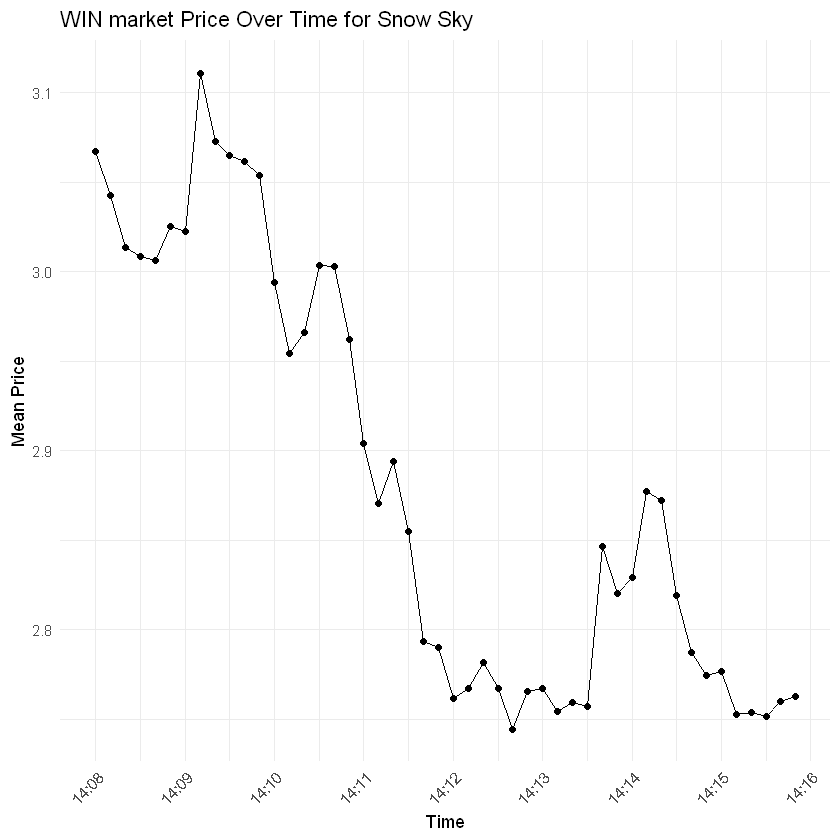

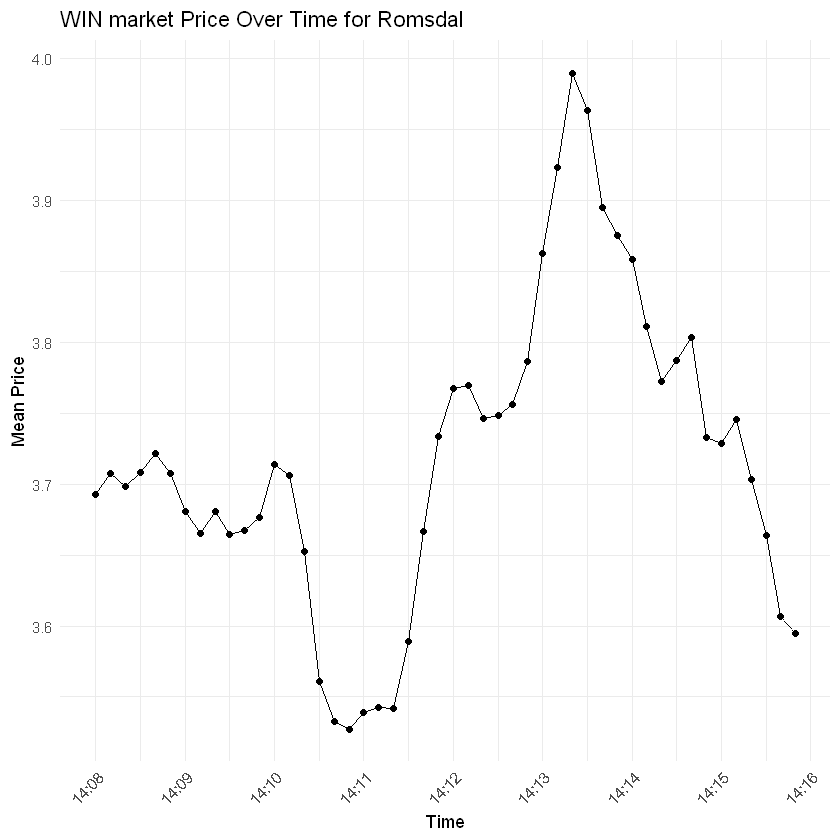

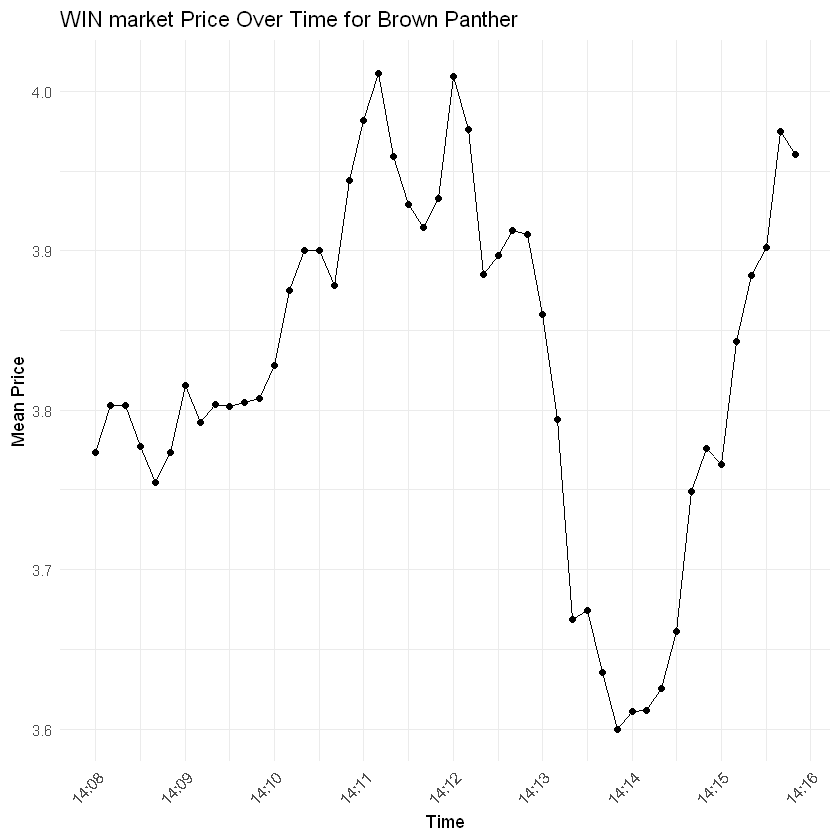

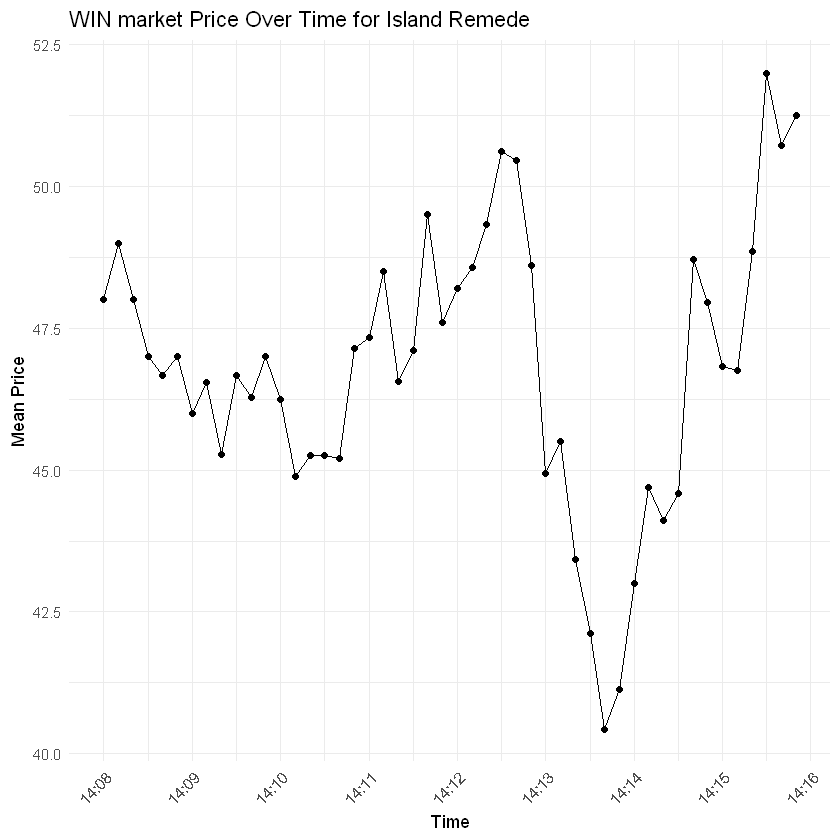

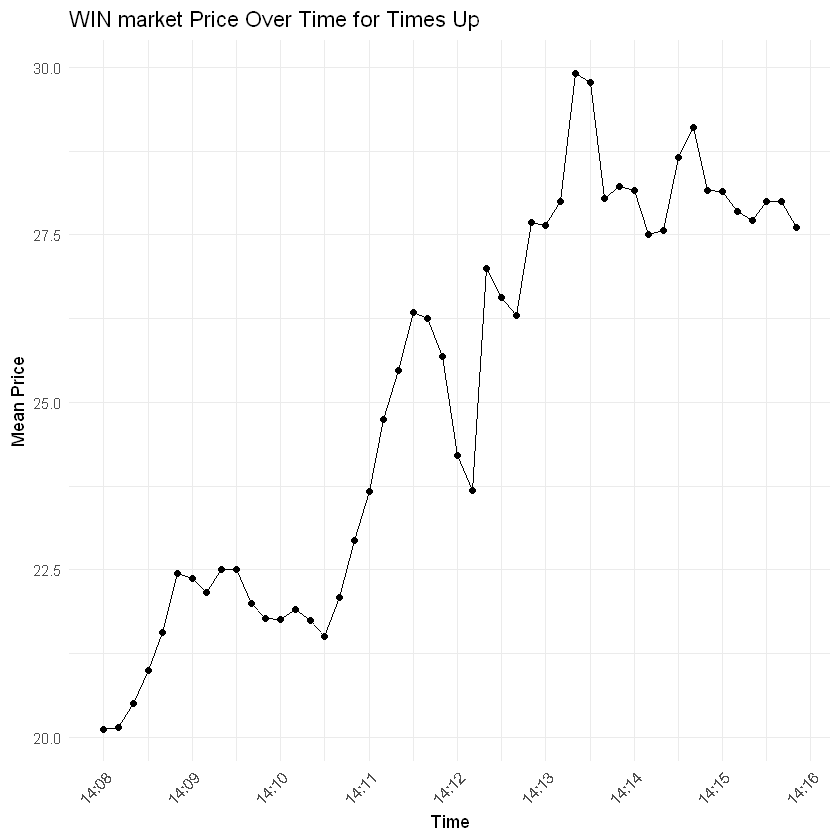

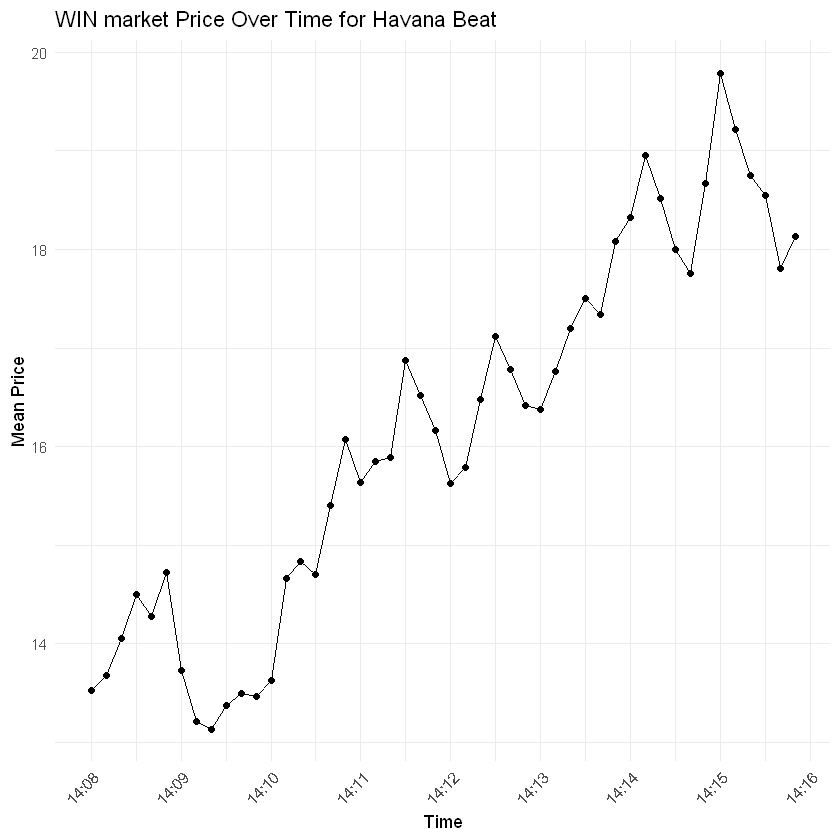

In [8]:
  par(mfrow = c(2, 3))

# Loop through each horse and create a plot and save dataframe for WIN_PRO_df
for (horse in unique(WIN_PRO_df$horse_name)) {
  horse_df <- WIN_PRO_df_PP %>% filter(horse_name == horse)
  
  # Calculate the size column for each horse within the loop
  #horse_df <- horse_df %>%
    #arrange(timestamp) %>%
    #mutate(size = traded_volume - lag(traded_volume, default = first(traded_volume)),
           #size = ifelse(size < 0, 0, size))
  
  # Group by six_sec_bucket and calculate the size and Mean Price
  horse_df <- horse_df %>%
    group_by(six_sec_bucket) %>%
    summarise(
      #total_size = sum(size, na.rm = TRUE),
      mean_price = mean(price, na.rm = TRUE)
    )
  
  # Save the horse-specific dataframe to a variable named after the horse
  assign(paste0(gsub(" ", "_", horse), "_WIN_df"), horse_df)


  # Partition the plot panel 2 rows and 3 column




  
  # Create the plot with only price
  p <- ggplot(data = horse_df, aes(x = as.POSIXct(six_sec_bucket * 10, origin = "1970-01-01", tz = "GMT"), y = mean_price)) +
    geom_line() +
    geom_point() +
    labs(
      title = paste("WIN market Price Over Time for", horse),
      x = "Time",
      y = "Mean Price"
    ) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "bottom"
    ) +
    scale_x_datetime(date_breaks = "1 min", date_labels = "%H:%M")
  
  # Print the plot
  print(p)
}
  

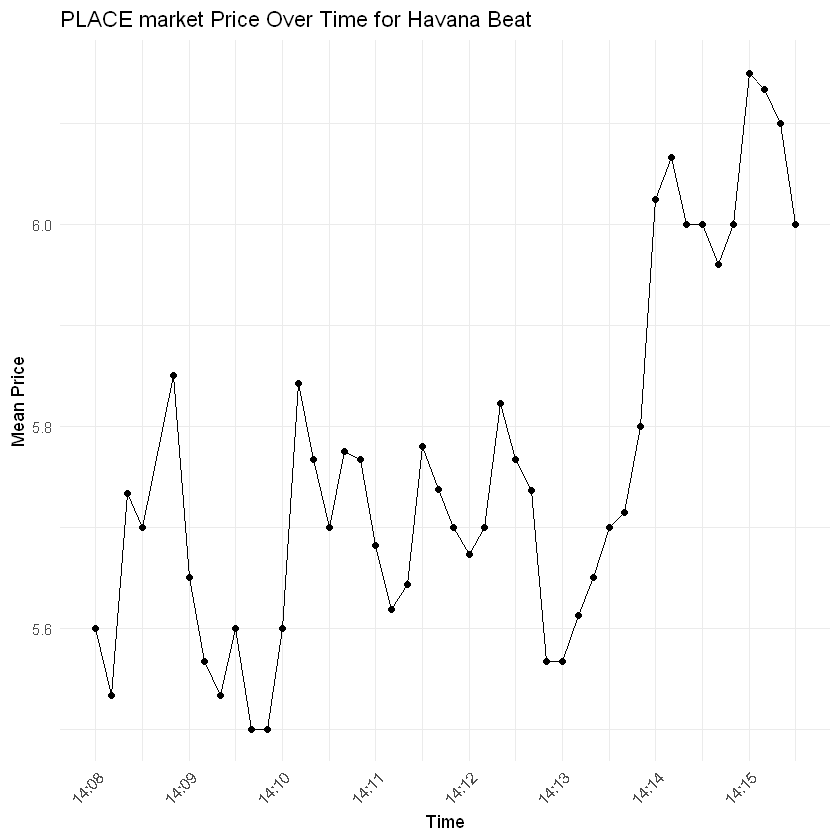

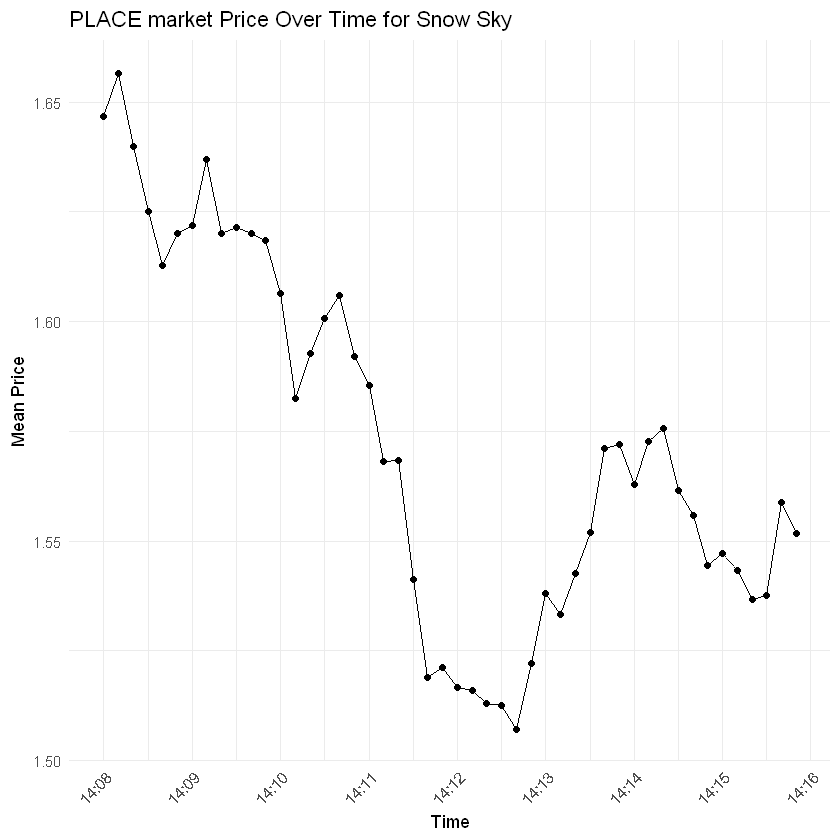

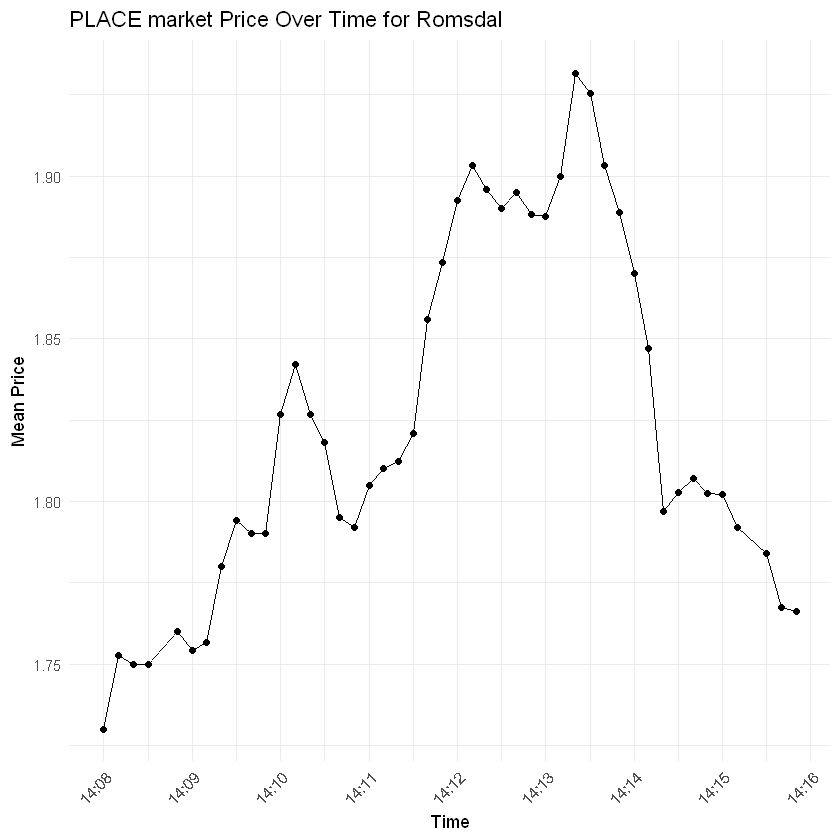

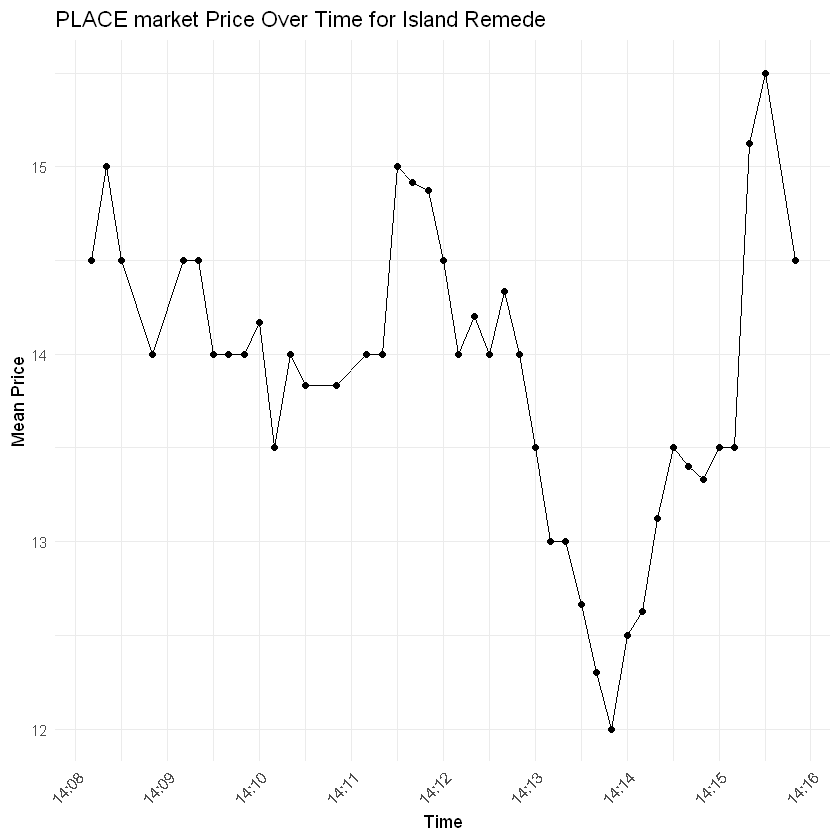

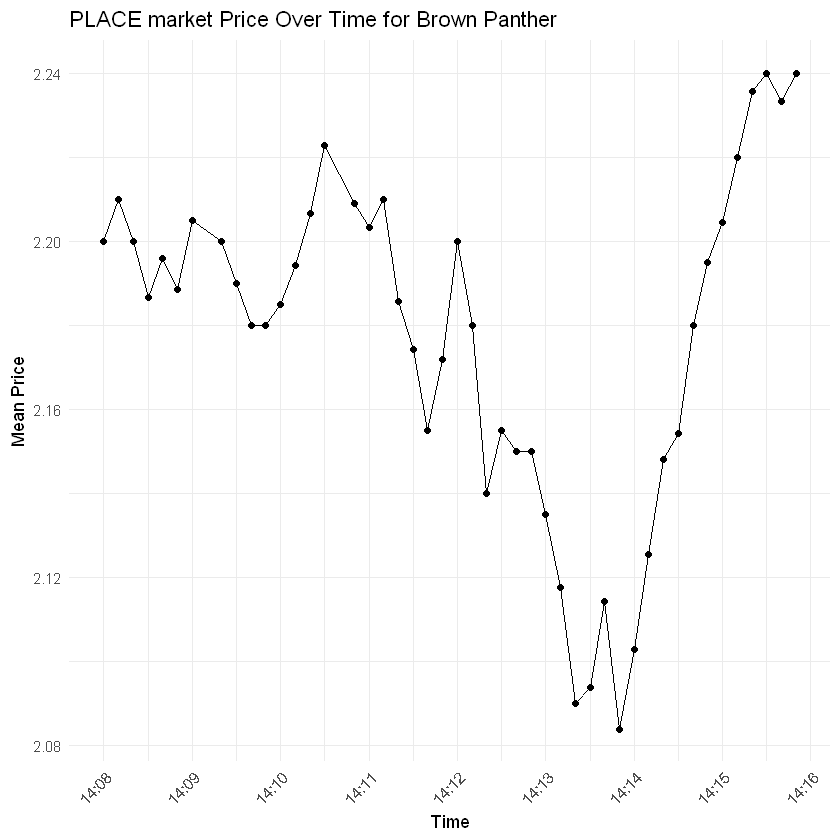

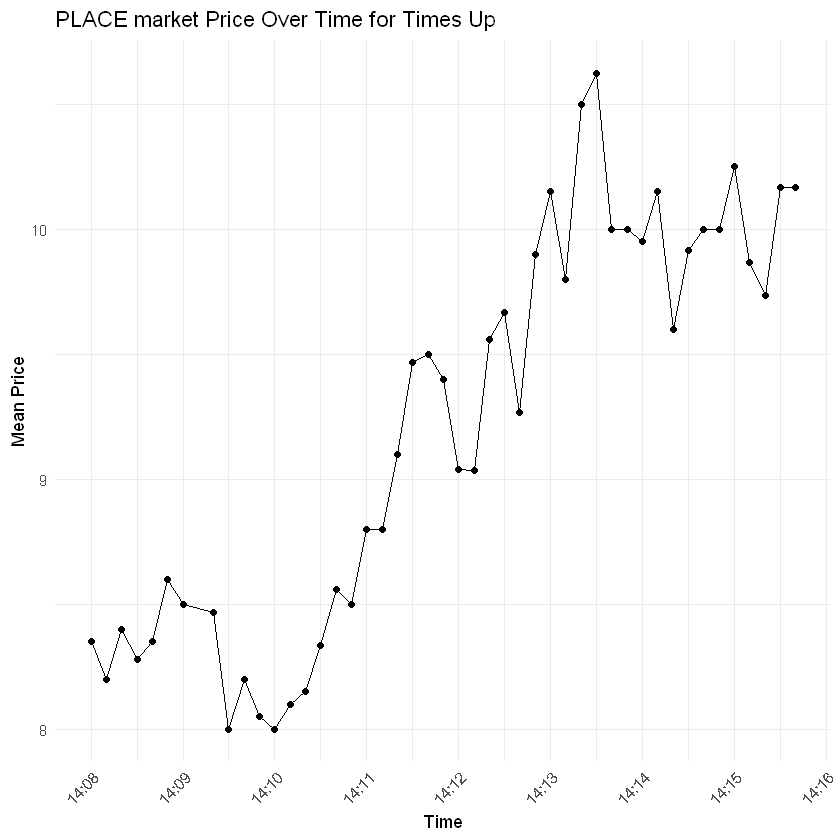

In [9]:
# Loop through each horse and create a plot and save dataframe for PLACE_PRO_df
for (horse in unique(PLACE_PRO_df$horse_name)) {
  horse_df <- PLACE_PRO_df_PP %>% filter(horse_name == horse)
  
  # Calculate the size column for each horse within the loop
  #horse_df <- horse_df %>%
    #arrange(timestamp) %>%
    #mutate(size = traded_volume - lag(traded_volume, default = first(traded_volume)),
           #size = ifelse(size < 0, 0, size))
  
  # Group by six_sec_bucket and calculate the size and Mean Price
  horse_df <- horse_df %>%
    group_by(six_sec_bucket) %>%
    summarise(
      #total_size = sum(size, na.rm = TRUE),
      #mean_price = sum(price * size, na.rm = TRUE) / sum(size, na.rm = TRUE)
      mean_price = mean(price, na.rm = TRUE)
    )
  
  # Save the horse-specific dataframe to a variable named after the horse
  assign(paste0(gsub(" ", "_", horse), "_PLACE_df"), horse_df)
  
  # Create the plot with only price
  p <- ggplot(data = horse_df, aes(x = as.POSIXct(six_sec_bucket * 10, origin = "1970-01-01", tz = "GMT"), y = mean_price)) +
    geom_line() +
    geom_point() +
    labs(
      title = paste("PLACE market Price Over Time for", horse),
      x = "Time",
      y = "Mean Price"
    ) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "bottom"
    ) +
    scale_x_datetime(date_breaks = "1 min", date_labels = "%H:%M")
  
  # Print the plot
  print(p)
}

### EXPLORATORY DATA ANALYSIS WIN MARKET (SELECTING SNOW SKY)


In [10]:
head(Snow_Sky_WIN_df)
head(Snow_Sky_PLACE_df)

six_sec_bucket,mean_price
<dbl>,<dbl>
143169888,3.067105
143169889,3.042593
143169890,3.013636
143169891,3.008537
143169892,3.006522
143169893,3.025000


six_sec_bucket,mean_price
<dbl>,<dbl>
143169888,1.646667
143169889,1.656667
143169890,1.640000
143169891,1.625000
143169892,1.612857
143169893,1.620000


In [11]:
# Load necessary libraries
library(tidyverse)
library(lubridate)
library(ggplot2)
library(forecast)
library(tseries)


####THIS FILTERING IS NOT REQUIRED, Snow_Sky_WIN_df is already prepared

# Assuming 'horse_trading_data' is your dataset containing all the trading information.

# Step 1: Data Preparation
# Filter the dataset for the horse named "Snow Sky Bird"
#snow_sky_df <- Snow_Sky_WIN_df %>%
  #filter(horse_name == "Snow Sky")

# Convert timestamps to proper datetime format if necessary
#snow_sky_df$timestamp <- as.POSIXct(snow_sky_df$timestamp, format="%Y-%m-%d %H:%M:%S")

# Ensure data is sorted by timestamp
#snow_sky_df <- arrange(snow_sky_df, timestamp)






In [12]:
# Step 2: Data Exploration
# Summary statistics of key variables

print(summary(Snow_Sky_WIN_df$mean_price))
print(summary(Snow_Sky_PLACE_df$mean_price))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.745   2.767   2.851   2.882   3.004   3.111 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.507   1.540   1.568   1.572   1.608   1.657 


In [13]:
# Check for missing values
print(sum(is.na(Snow_Sky_WIN_df$mean_price)))
print(sum(is.na(Snow_Sky_PLACE_df$mean_price)))

# Check duplicate rows
print(sum(duplicated(Snow_Sky_WIN_df)))
print(sum(duplicated(Snow_Sky_PLACE_df)))

[1] 0
[1] 0
[1] 0
[1] 0


In [14]:
str(Snow_Sky_WIN_df)
str(Snow_Sky_PLACE_df)

tibble [48 × 2] (S3: tbl_df/tbl/data.frame)
 $ six_sec_bucket: num [1:48] 1.43e+08 1.43e+08 1.43e+08 1.43e+08 1.43e+08 ...
 $ mean_price    : num [1:48] 3.07 3.04 3.01 3.01 3.01 ...
tibble [48 × 2] (S3: tbl_df/tbl/data.frame)
 $ six_sec_bucket: num [1:48] 1.43e+08 1.43e+08 1.43e+08 1.43e+08 1.43e+08 ...
 $ mean_price    : num [1:48] 1.65 1.66 1.64 1.62 1.61 ...


In [15]:
#USE NEXT CELL

# Extract the price data
#price_data <- Snow_Sky_WIN_df$mean_price

# Create a time series object with a frequency of 1 observation per second
#win_price_ts <- ts(price_data, frequency = 1, start = c(2015, as.numeric(format(min(Snow_Sky_WIN_df$six_sec_bucket), "%j"))))

# Check the structure of the time series object
#str(win_price_ts)



#head(win_price_ts)

In [16]:
# Convert 'six_sec_bucket' to POSIXct for proper time handling
Snow_Sky_WIN_df <- Snow_Sky_WIN_df %>%
  mutate(timestamp = as.POSIXct(six_sec_bucket * 10, origin = "1970-01-01", tz = "GMT"))

# Check the range of the timestamp
start_time <- min(Snow_Sky_WIN_df$timestamp)
end_time <- max(Snow_Sky_WIN_df$timestamp)

# Create a sequence of time points from start to end with a step of 6 seconds
time_points <- seq(from = start_time, to = end_time, by = "10 sec")

# Create a complete data frame with these time points
complete_data <- data.frame(timestamp = time_points)

# Merge with the original data to ensure alignment
complete_data <- complete_data %>%
  left_join(Snow_Sky_WIN_df, by = "timestamp")

# Fill missing prices with NA or any other method if necessary
complete_data <- complete_data %>%
  mutate(mean_price = ifelse(is.na(mean_price), NA, mean_price))

# Check the filled price data
summary(complete_data$mean_price)

# Extract the filled price data
filled_price_data <- complete_data$mean_price

# Create the time series object
# Use a lower frequency to match the length of the time series
# For example, assuming a reasonable periodicity within the data length
win_price_ts <- ts(filled_price_data, frequency = 10)

# Check the structure and length of the time series object
str(win_price_ts)
length(win_price_ts)

# Display the first few entries of the time series object
head(win_price_ts)



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.745   2.767   2.851   2.882   3.004   3.111 

 Time-Series [1:48] from 1 to 5.7: 3.07 3.04 3.01 3.01 3.01 ...


[1] 48

A Time Series:
[1] 3.067105 3.042593 3.013636 3.008537 3.006522 3.025000

In [17]:
# Convert 'six_sec_bucket' to POSIXct for proper time handling
Snow_Sky_PLACE_df <- Snow_Sky_PLACE_df %>%
  mutate(timestamp = as.POSIXct(six_sec_bucket * 10, origin = "1970-01-01", tz = "GMT"))

# Check the range of the timestamp
start_time <- min(Snow_Sky_PLACE_df$timestamp)
end_time <- max(Snow_Sky_PLACE_df$timestamp)

# Create a sequence of time points from start to end with a step of 6 seconds
time_points <- seq(from = start_time, to = end_time, by = "10 sec")

# Create a complete data frame with these time points
complete_data <- data.frame(timestamp = time_points)

# Merge with the original data to ensure alignment
complete_data <- complete_data %>%
  left_join(Snow_Sky_PLACE_df, by = "timestamp")

# Fill missing prices with NA or any other method if necessary
complete_data <- complete_data %>%
  mutate(mean_price = ifelse(is.na(mean_price), NA, mean_price))

# Check the filled price data
summary(complete_data$mean_price)

# Extract the filled price data
filled_price_data <- complete_data$mean_price

# Create the time series object
# Use a lower frequency to match the length of the time series
# For example, assuming a reasonable periodicity within the data length
PLACE_price_ts <- ts(filled_price_data, frequency = 10)

# Check the structure and length of the time series object
str(PLACE_price_ts)
length(PLACE_price_ts)

# Display the first few entries of the time series object
head(PLACE_price_ts)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.507   1.540   1.568   1.572   1.608   1.657 

 Time-Series [1:48] from 1 to 5.7: 1.65 1.66 1.64 1.62 1.61 ...


[1] 48

A Time Series:
[1] 1.646667 1.656667 1.640000 1.625000 1.612857 1.620000

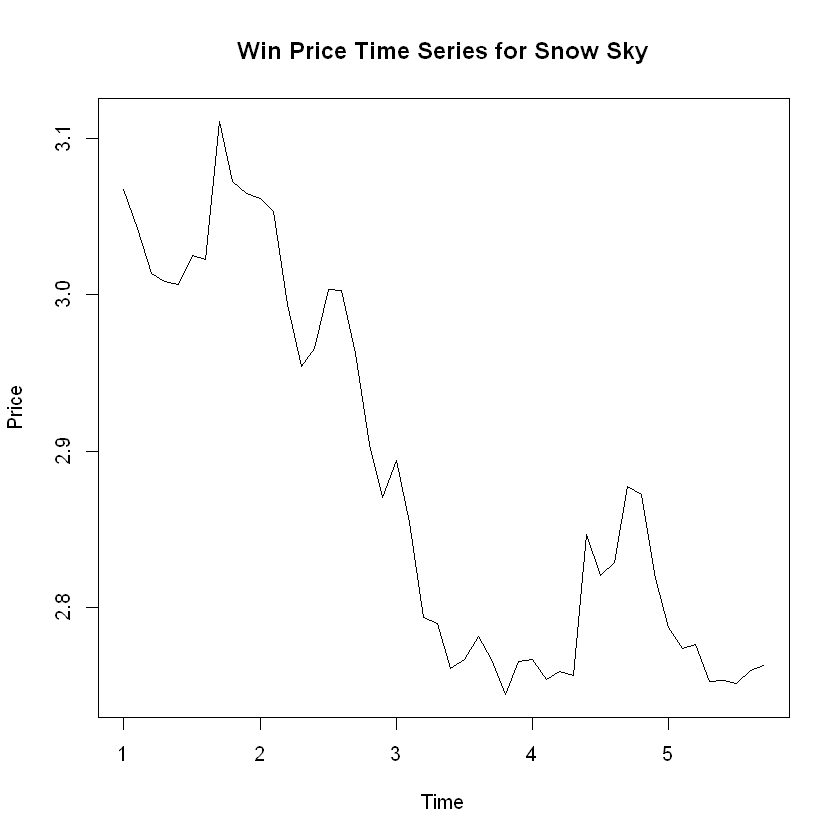

In [18]:
plot(win_price_ts, main="Win Price Time Series for Snow Sky", xlab="Time", ylab="Price", type="l")


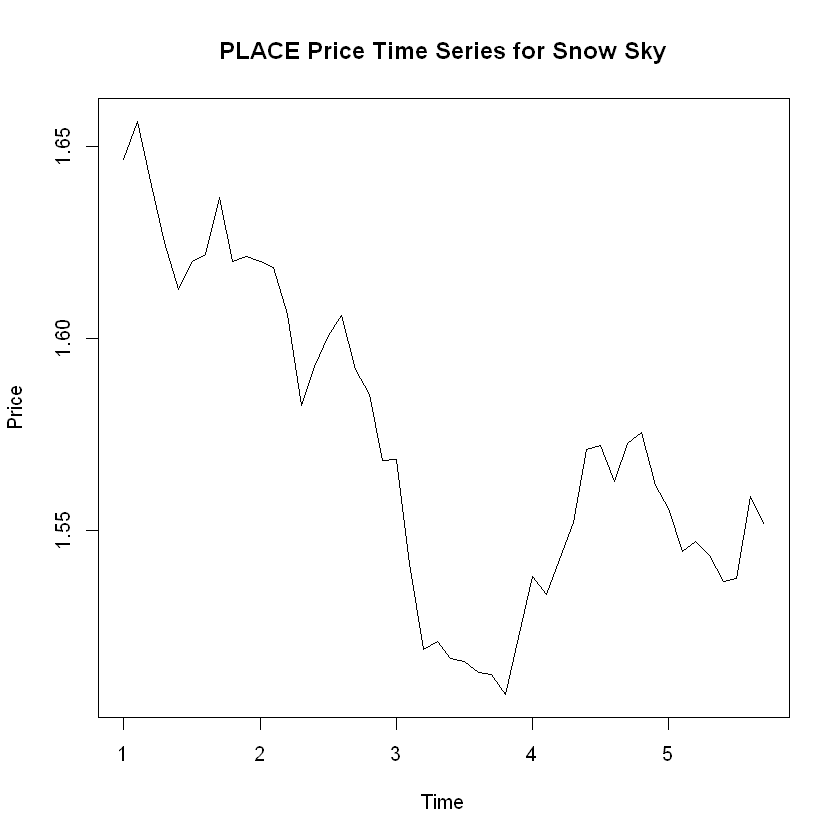

In [19]:
plot(PLACE_price_ts, main="PLACE Price Time Series for Snow Sky", xlab="Time", ylab="Price", type="l")

In [20]:
# Step 4: Statistical Tests
# Testing for stationarity
adf_test_result <- adf.test(win_price_ts, alternative = "stationary")
print(adf_test_result)

adf_test_result_2 <- adf.test(PLACE_price_ts, alternative = "stationary")
print(adf_test_result_2)




	Augmented Dickey-Fuller Test

data:  win_price_ts
Dickey-Fuller = -1.6289, Lag order = 3, p-value = 0.7223
alternative hypothesis: stationary


	Augmented Dickey-Fuller Test

data:  PLACE_price_ts
Dickey-Fuller = -1.3241, Lag order = 3, p-value = 0.844
alternative hypothesis: stationary



Its not stationary. Therefore we need to break it down and to understand the underlying components.


In [21]:
#NOT SURE IF THIS IS REQUIRED?
# Enhanced boxplot visualization of monthly price distribution per year
# Snow_Sky_WIN_df %>%
#   mutate(year = year(timestamp), month = month(timestamp), month_name = month(timestamp, label = TRUE)) %>%
#   ggplot(aes(x = month_name, y = price, fill = month_name)) +  # Use month name and fill by month
#   geom_boxplot(outlier.shape = NA) +  # Remove default outlier points
#   geom_jitter(width = 0.1, alpha = 0.5, color = "darkgray") +  # Add jittered points for individual data observation
#   scale_fill_brewer(palette = "Paired") +  # Apply a color palette for aesthetics
#   labs(title = "Price Distribution ",
#        subtitle = "Snow Sky",) +
#   facet_wrap(~year) +  # Facet by year to see year-wise trends
#   theme_minimal() +  # Use a minimal theme
#   theme(
#     strip.background = element_rect(fill = "lightblue", color = "deepskyblue", size = 1),  # Customize facet headers
#     strip.text = element_text(face = "bold"),  # Bold facet header text
#     axis.text.x = element_text(angle = 45, hjust = 1),  # Improve x-axis label readability
#     legend.position = "none",  # Hide the legend as the color is self-explanatory
#     plot.title = element_text(hjust = 0.5),  # Center the title
#     plot.subtitle = element_text(hjust = 0.5)  # Center the subtitle
#   )


In [22]:
# Step 5: Decomposition of Time Series (if seasonal patterns expected)

# Install necessary packages if not already installed
# install.packages("tsibble")
# install.packages("feasts")
# install.packages("fabletools")

# Load necessary libraries
library(tidyverse)
library(lubridate)
library(tsibble)
library(feasts)
library(fabletools)







Attaching package: 'tsibble'


The following object is masked from 'package:zoo':

    index


The following object is masked from 'package:lubridate':

    interval


The following objects are masked from 'package:base':

    intersect, setdiff, union


Loading required package: fabletools



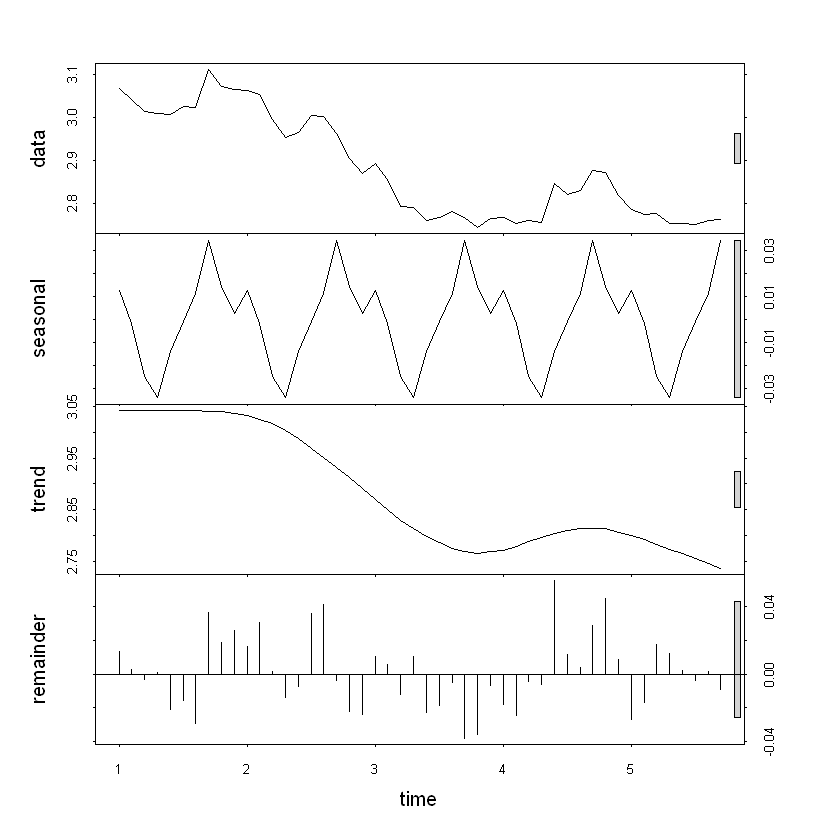

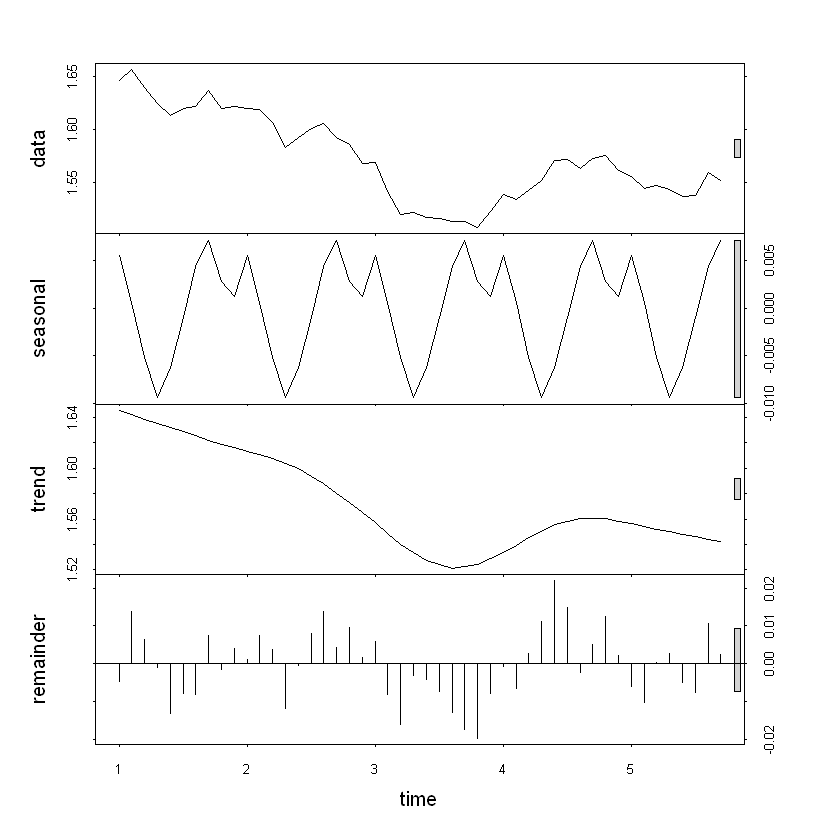

In [23]:
# Step 5: Decomposition of Time Series (if seasonal patterns expected)
decomposed <- stl(win_price_ts, s.window = "periodic")
plot(decomposed)

decomposed_2 <- stl(PLACE_price_ts, s.window = "periodic")
plot(decomposed_2)



In [24]:
snow_sky_diff_1 <- diff(Snow_Sky_WIN_df$mean_price, lag = 1)

snow_sky_diff_P1 <- diff(Snow_Sky_PLACE_df$mean_price, lag = 1)


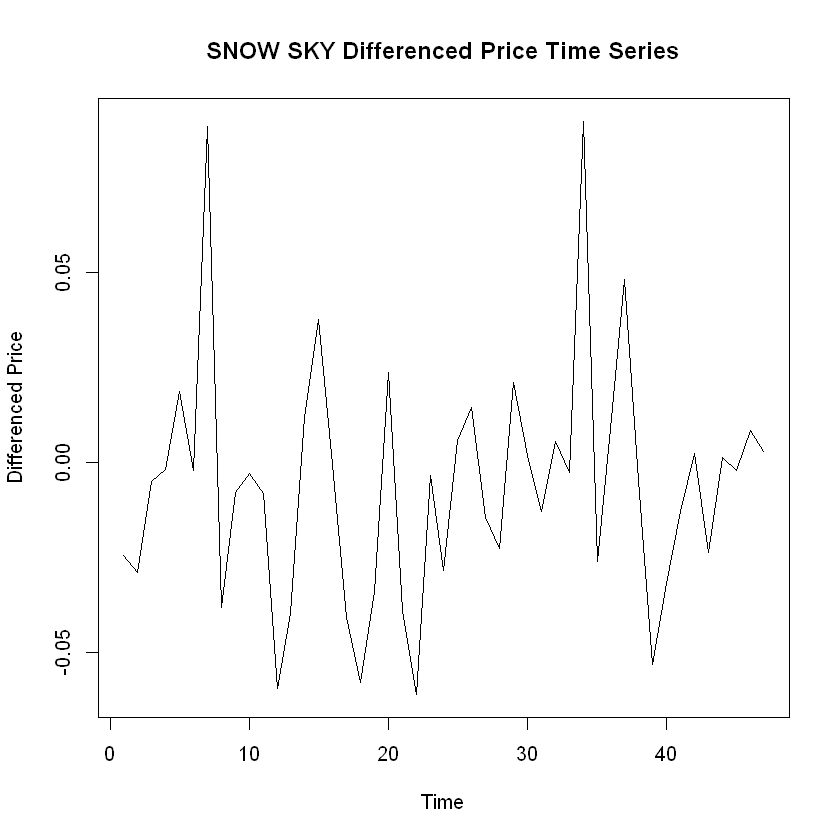

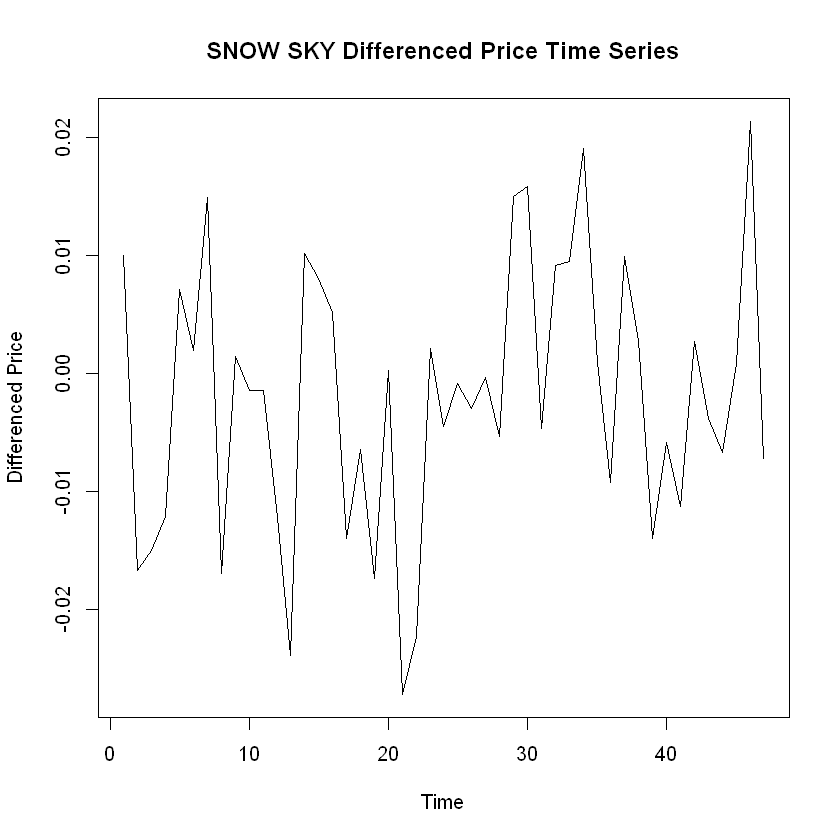

In [25]:
plot(snow_sky_diff_1, main="SNOW SKY Differenced Price Time Series", xlab="Time", ylab="Differenced Price", type="l")

plot(snow_sky_diff_P1, main="SNOW SKY Differenced Price Time Series", xlab="Time", ylab="Differenced Price", type="l")

In [26]:
adf_result_diff <- adf.test(snow_sky_diff_1, alternative = "stationary")
print(adf_result_diff)

adf_result_diff_P <- adf.test(snow_sky_diff_P1, alternative = "stationary")
print(adf_result_diff_P)


	Augmented Dickey-Fuller Test

data:  snow_sky_diff_1
Dickey-Fuller = -2.8935, Lag order = 3, p-value = 0.218
alternative hypothesis: stationary


	Augmented Dickey-Fuller Test

data:  snow_sky_diff_P1
Dickey-Fuller = -2.5124, Lag order = 3, p-value = 0.3698
alternative hypothesis: stationary



#P-Value > 0.05, hence we take do another differential

In [27]:
snow_sky_diff_2 <- diff(snow_sky_diff_1, lag = 1)

snow_sky_diff_P2 <- diff(snow_sky_diff_P1, lag = 1)

In [28]:
adf.test(snow_sky_diff_2, alternative = "stationary")

adf.test(snow_sky_diff_P2, alternative = "stationary")

Warning message in adf.test(snow_sky_diff_2, alternative = "stationary"):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  snow_sky_diff_2
Dickey-Fuller = -5.2098, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(snow_sky_diff_P2, alternative = "stationary"):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  snow_sky_diff_P2
Dickey-Fuller = -5.3273, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


### VAR MODEL FOR WIN MARKET AND PLACE MARKET


In [29]:
# Check the size of both the time series

length(snow_sky_diff_2)
length(snow_sky_diff_P2)

[1] 46

[1] 46

In [30]:
# Loading required package and importing data
install.packages("vars")
install.packages("tseries")
install.packages("quantmod")
library(vars)
library(tseries)
library(quantmod)

Installing package into 'C:/Users/samue/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'vars' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\samue\AppData\Local\Temp\RtmpIjfr6T\downloaded_packages


Warning message:
"package 'tseries' is in use and will not be installed"
Warning message:
"package 'quantmod' is in use and will not be installed"
Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: strucchange

Loading required package: sandwich


Attaching package: 'strucchange'


The following object is masked from 'package:stringr':

    boundary


Loading required package: urca

Loading required package: lmtest



In [32]:
# Estimating vector autoregression and testing for causality

VAR_est <- VAR(cbind(snow_sky_diff_2,snow_sky_diff_P2), ic="AIC", lag.max = 20)
coeftest(VAR_est)
causality(VAR_est, cause="snow_sky_diff_2")["Granger"]
causality(VAR_est, cause="snow_sky_diff_P2")["Granger"]

# Interpretation: The Granger-causality test states that at the 95% confidence interval, oil returns do significantly Granger-cause the inflation rate but not vice versa.




t test of coefficients:

                                         Estimate  Std. Error t value Pr(>|t|)
snow_sky_diff_2:(Intercept)            0.00124842  0.00638089  0.1956 0.851342
snow_sky_diff_2:snow_sky_diff_2.l1    -0.34104360  0.39455164 -0.8644 0.420586
snow_sky_diff_2:snow_sky_diff_P2.l1   -1.49130582  1.24835875 -1.1946 0.277315
snow_sky_diff_2:snow_sky_diff_2.l2    -0.29029118  0.57473487 -0.5051 0.631509
snow_sky_diff_2:snow_sky_diff_P2.l2   -1.09049903  1.59117416 -0.6853 0.518715
snow_sky_diff_2:snow_sky_diff_2.l3    -0.53154976  0.61950902 -0.8580 0.423826
snow_sky_diff_2:snow_sky_diff_P2.l3    0.61371262  1.60678948  0.3819 0.715660
snow_sky_diff_2:snow_sky_diff_2.l4    -0.62596176  0.68160005 -0.9184 0.393844
snow_sky_diff_2:snow_sky_diff_P2.l4    2.57108562  1.57247706  1.6351 0.153155
snow_sky_diff_2:snow_sky_diff_2.l5    -0.33509693  0.75343603 -0.4448 0.672089
snow_sky_diff_2:snow_sky_diff_P2.l5    1.15433267  1.77618703  0.6499 0.539830
snow_sky_diff_2:snow_sky_d

$Granger

	Granger causality H0: snow_sky_diff_2 do not Granger-cause
	snow_sky_diff_P2

data:  VAR object VAR_est
F-Test = 2.3683, df1 = 13, df2 = 12, p-value = 0.07277



$Granger

	Granger causality H0: snow_sky_diff_P2 do not Granger-cause
	snow_sky_diff_2

data:  VAR object VAR_est
F-Test = 1.3591, df1 = 13, df2 = 12, p-value = 0.301



In [ ]:
# Degression: Plotting impulse response functions
plot(irf(VAR_est, impulse="win_price_ts", response="PLACE_price_ts"))
plot(irf(VAR_est, impulse="PLACE_price_ts", response="win_price_ts"))

# Interpretation: A shock in the inflation rate does not have an effect on oil returns, whereas a shock in oil returns has a positive effect on the inflation rate in the first months after the shock.